#👩‍💻 데이터 정리 시작!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import chi2_contingency

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv', index_col = 0)
#df.head()
#df.shape
#df.dtypes

######✍️ Sales에서 K, M과 같은 단위들을 정리

In [ ]:
df['NA_Sales'] = pd.to_numeric(df.NA_Sales.str.translate(str.maketrans({'K':'e-3','M':''})))
df['EU_Sales'] = pd.to_numeric(df.EU_Sales.str.translate(str.maketrans({'K':'e-3','M':''})))
df['JP_Sales'] = pd.to_numeric(df.JP_Sales.str.translate(str.maketrans({'K':'e-3','M':''})))
df['Other_Sales'] = pd.to_numeric(df.Other_Sales.str.translate(str.maketrans({'K':'e-3','M':''})))
df.columns = ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA', 'EU', 'JP', 'Other']
#df.head(15)
#df.dtypes
df.isna().sum()

Name           0
Platform       0
Year         271
Genre         50
Publisher     58
NA             0
EU             0
JP             0
Other          0
dtype: int64

######✍️ 'Year'에서 2009 -> 9/ 1997 -> 97 같은 데이터들 정리

In [ ]:
for i in range(len(df['Year'])):
  if df.iloc[i, 2] < 100:
    if df.iloc[i, 2] < 50:
      df.iloc[i, 2] = df.iloc[i, 2] + 2000
    else:
      df.iloc[i, 2] = df.iloc[i, 2] + 1900

In [ ]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04


######✍️ 'Publisher', 'platform'에서 오류로 보이는 데이터 -> Unknown처리 및 중요한 요소인 'Year' & 'Genre' NaN값 drop

In [ ]:
df['Publisher'].fillna(value = 'Unknown', inplace = True)
df['Platform'] = df['Platform'].replace(['2600'],'Unknown')
df = df.dropna()
df.Year = df.Year.astype(int)

In [ ]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04


In [ ]:
df.isna().sum().sum()
#df.dtypes

0

#✍️ 데이터 정리 완료!

In [ ]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04


# ❓지역에 따라서 선호하는 게임 장르가 다를까❓

#### ✍️ 선호하는 게임의 장르를 알아보기 위해서는 각 지역 총매출에서 장르별 게임이 차지하는 percentage를 비교하면 좋다고 생각했다.

######✍️ Percentage를 알기 위해서 계산해서 넣음

In [ ]:
df1 = df.groupby(by = ['Genre'], as_index = False).sum()
df1 = df1.drop('Year', axis = 1)
df2 = pd.DataFrame(index = range(0, 12), columns = ['NA_percent','EU_percent', 'JP_percent', 'Other_percent'])
df2 = df2.fillna(0)
for i in np.arange(1, 5):
  a = df1.iloc[:, i].sum()
  for m in np.arange(0, len(df2)):
    df2.iloc[m, i-1] = df1.iloc[m, i]*100/a
df3 = pd.concat([df1['Genre'], df2], axis = 1)
df3.head()

,Genre,NA_percent,EU_percent,JP_percent,Other_percent
0,Action,19.912262,21.437396,12.317723,23.483988
1,Adventure,2.363187,2.659015,4.081263,2.131543
2,Fighting,5.109186,4.169449,6.853754,4.614089
3,Misc,9.281398,8.772955,8.193988,9.284338
4,Platform,10.326886,8.374374,10.266474,6.566939


In [ ]:
df_melt3 = df3.melt(id_vars = 'Genre', value_vars = ['NA_percent', 'EU_percent', 'JP_percent', 'Other_percent'])
df_melt3.columns = ['Genre', 'Country', 'Sales_percent']
df_melt3.head()

,Genre,Country,Sales_percent
0,Action,NA_percent,19.912262
1,Adventure,NA_percent,2.363187
2,Fighting,NA_percent,5.109186
3,Misc,NA_percent,9.281398
4,Platform,NA_percent,10.326886


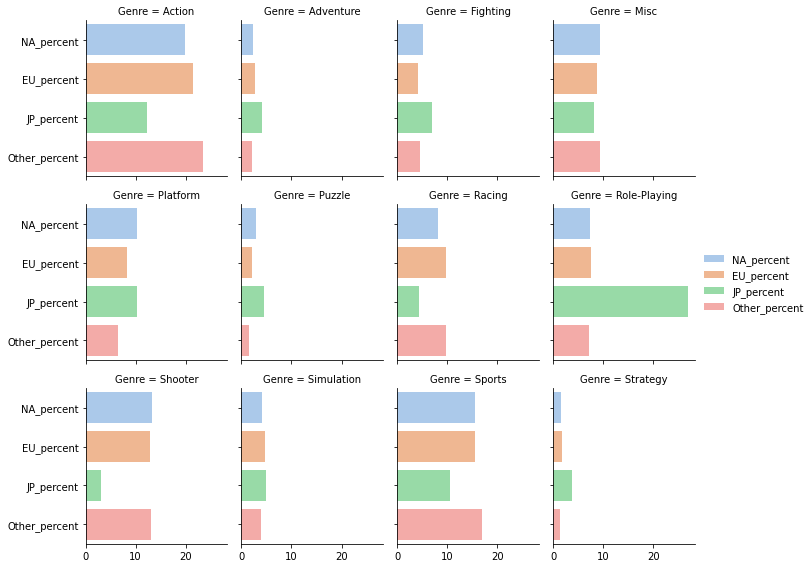

In [ ]:
g = sns.FacetGrid(data = df_melt3, col = 'Genre', palette = 'pastel', height = 3, col_wrap = 4)

fig = plt.gcf()

fig.set_size_inches(10, 8)

g.map_dataframe(
    sns.barplot,
    x = 'Sales_percent',
    y = 'Country',
    hue = 'Country',
    data = df_melt3,
    palette = 'pastel',
    dodge = False,
    )
g.add_legend();

######✍️ 다른 나라들의 게임 장르별 선호도는 비슷한데, 유독 일본에서 Role-Playing을 선호하는 경향을 보임 -> 직관적으로

#✍️ Two-way ANOVA TEST 시작

####✍️ 통계적인 근거를 얻기위해 ANOVA TEST를 채택, 진행

###### ✍️ ANOVA TEST를 위해 데이터 정규화 작업

In [ ]:
df_test2 = df
df_test2 = df_test2.drop('Name', axis = 1)
df_test2 = df_test2.drop('Year', axis = 1)
df_test2 = df_test2.drop('Platform', axis = 1)
df_test2 = df_test2.drop('Publisher', axis = 1)
df_test2.head()

,Genre,NA,EU,JP,Other
1,Action,0.04,0.00,0.00,0.00
2,Action,0.17,0.00,0.00,0.01
3,Adventure,0.00,0.00,0.02,0.00
4,Misc,0.04,0.00,0.00,0.00
5,Platform,0.12,0.09,0.00,0.04


In [ ]:
index = df_test2['Genre']
index.reset_index
index.head()

1       Action
2       Action
3    Adventure
4         Misc
5     Platform
Name: Genre, dtype: object

In [ ]:
index = pd.DataFrame(index)
index.reset_index(inplace = True, col_level = 0, drop = True)
index.head()

,Genre
0,Action
1,Action
2,Adventure
3,Misc
4,Platform


In [ ]:
df_test2 = df_test2.set_index('Genre')
df_test2.head()

,NA,EU,JP,Other
Genre,,,,
Action,0.04,0.00,0.00,0.00
Action,0.17,0.00,0.00,0.01
Adventure,0.00,0.00,0.02,0.00
Misc,0.04,0.00,0.00,0.00
Platform,0.12,0.09,0.00,0.04


In [ ]:
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(df_test2)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['NA', 'EU', 'JP', 'Other']
data_scaled = pd.concat([index, data_scaled], axis = 1)
data_scaled.head()

,Genre,NA,EU,JP,Other
0,Action,-0.273825,-0.289889,-0.252836,-0.254037
1,Action,-0.115590,-0.289889,-0.252836,-0.201260
2,Adventure,-0.322513,-0.289889,-0.188098,-0.254037
3,Misc,-0.273825,-0.289889,-0.252836,-0.254037
4,Platform,-0.176449,-0.112649,-0.252836,-0.042927


######✍️ library쓰기위해 tidy형태로 만들어주기

In [ ]:
df_melt_scaled = data_scaled.melt(id_vars = ['Genre'], value_vars = ['NA', 'EU', 'JP', 'Other'])
df_melt_scaled.columns = ['Genre', 'Country', 'Sales']
df_melt_scaled.head()

,Genre,Country,Sales
0,Action,NA,-0.273825
1,Action,NA,-0.115590
2,Adventure,NA,-0.322513
3,Misc,NA,-0.273825
4,Platform,NA,-0.176449


In [ ]:
model = ols('Sales ~ C(Genre) + C(Country) + C(Genre):C(Country)', data = df_melt_scaled).fit()
result = sm.stats.anova_lm(model, typ = 3)
result

,sum_sq,df,F,PR(>F)
Intercept,1.586084,1.0,1.611751,2.042504e-01
C(Genre),161.326219,11.0,14.903351,2.282135e-29
C(Country),37.788168,3.0,12.799890,2.338597e-08
C(Genre):C(Country),615.559744,33.0,18.955181,5.477373e-110
Residual,64023.939242,65060.0,NaN,NaN


$H_0$:장르별 Sales에 차이가 없다.

국가별 Sales 분산에 차이가 없다.

장르와 국가별 Sales에 차이가 없다.

$H_1$:장르별 Sales에 차이가 있다.

국가별 Sales 분산에 차이가 있다.

장르와 국가별 Sales에 차이가 있다.

👉 모든 귀무가설 Reject, 모두 차이가 있다.

######✍️ 일본 빼고 가설검정

In [ ]:
data_scaled2 = data_scaled.drop('JP', axis = 1)
df_melt_scaled2 = data_scaled2.melt(id_vars = ['Genre'], value_vars = ['NA', 'EU', 'Other'])
df_melt_scaled2.columns = ['Genre', 'Country', 'Sales']
df_melt_scaled2.head()

,Genre,Country,Sales
0,Action,NA,-0.273825
1,Action,NA,-0.115590
2,Adventure,NA,-0.322513
3,Misc,NA,-0.273825
4,Platform,NA,-0.176449


In [ ]:
model2 = ols('Sales ~ C(Genre) + C(Country) + C(Genre):C(Country)', data = df_melt_scaled2).fit()
result2 = sm.stats.anova_lm(model2, typ = 3)
result2

,sum_sq,df,F,PR(>F)
Intercept,1.586084,1.0,1.602920,2.054959e-01
C(Genre),161.326219,11.0,14.821696,3.593156e-29
C(Country),3.367482,2.0,1.701614,1.823998e-01
C(Genre):C(Country),39.845543,22.0,1.830386,1.007933e-02
Residual,48282.491901,48795.0,NaN,NaN


$H_0$:

1) 장르별 Sales에 차이가 없다.

2) 국가별 Sales 분산에 차이가 없다.

3) 장르와 국가별 Sales에 차이가 없다.

$H_1$:

1) 장르별 Sales에 차이가 있다.

2) 국가별 Sales 분산에 차이가 있다.

3) 장르와 국가별 Sales에 차이가 있다.

👉 유의수준이 5% 혹은 10%라면, Not Reject $H_0$ of 2). 

국가별 Sales 분산에 유의미한 차이가 없다(데이터를 나라별로 정규화 했기 때문에).

나머지는 Reject $H_0$ 유의미한 차이가 있다.

❗️ 유의수준을 1%로 보게 된다면, Not Reject $H_0$ of 3) as well. ❗️

즉, '차이가 없다'의 기준을 넓힌다면 장르와 국가별 Sales에도 차이가 없다.

👉 (일본 제외)국가에 따라서 선호하는 게임 장르가 다르지 않다.

#🙌 ANOVA TEST 끝

#❓그렇다면 일본이 게임 시장 매출에 끼치는 영향은 클까❓

#### ✍️ 그렇다면 일본의 선호도를 고려해야 할 만큼 게임 시장 매출에 끼치는 영향이 큰지가 중요하다고 판단, 분석 시작.

In [ ]:
df.sum()[-4:]

NA       4312.82
EU          2396
JP       1271.42
Other     783.47
dtype: object

In [ ]:
df.sum()[-2]/(df.sum()[-4] + df.sum()[-3] + df.sum()[-2] + df.sum()[-1])

0.14507782662822027

# ❓연도별 게임의 트렌드가 있을까❓

# 🧾장르를 먼저 살펴보자

######✍️ 게임을 설계하기 위해 알아볼 필요가 있는 트렌드는 'Genre' & 'Platform'이라고 판단

#### ✍️ 게임의 트렌드는 Sales가 직관적으로 보여준다고 생각해서 Sales를 value로 잡고 매년의 Top1 게임을 뽑아 보았다.

In [ ]:
df_year = df
df_year['Sales'] = df_year['NA'] + df_year['EU'] + df_year['JP'] + df_year['Other']
df_year = df_year[['Year', 'Genre', 'Sales']]
df_year.head()

,Year,Genre,Sales
1,2008,Action,0.04
2,2009,Action,0.18
3,2010,Adventure,0.02
4,2010,Misc,0.04
5,2010,Platform,0.25


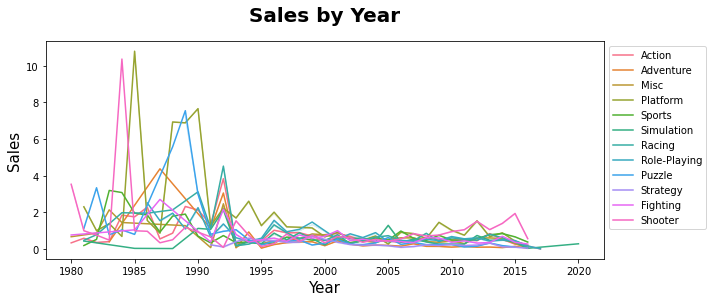

In [ ]:
plt.figure(figsize = (10, 4))
sns.set_palette('pastel')
sns.lineplot(x = 'Year', y = 'Sales', hue = 'Genre', data = df_year, ci = 0)
plt.title('Sales by Year', fontweight = 'bold', fontsize = 20, pad = 20)
plt.legend(bbox_to_anchor = (1, 1), loc = 2)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Sales', fontsize = 15);

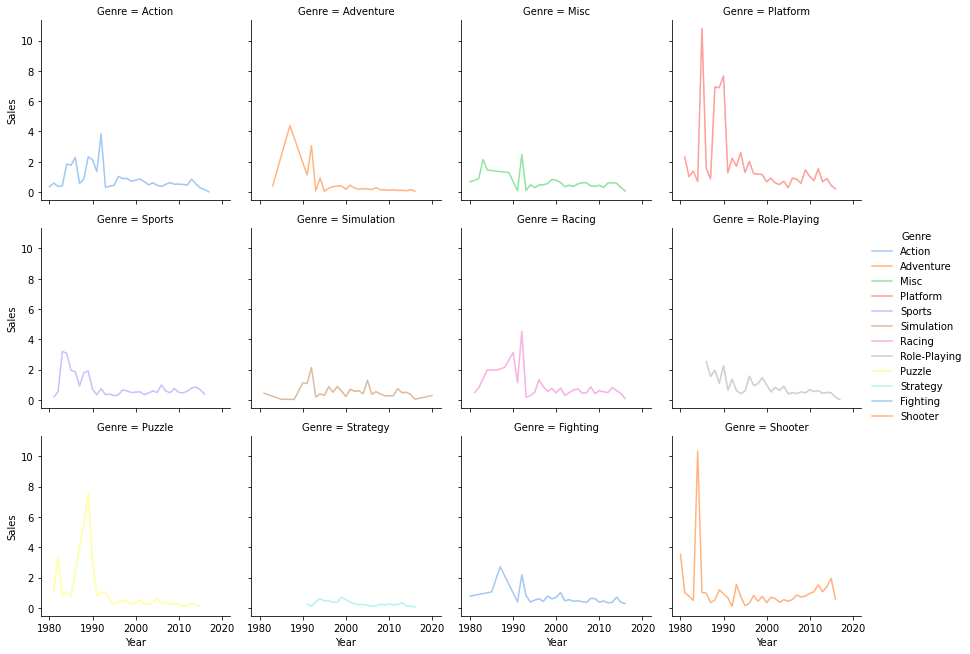

In [ ]:
sns.relplot(x = 'Year', y = 'Sales', col = 'Genre', hue = 'Genre', kind = 'line', data = df_year, height = 3, col_wrap = 4, palette = 'pastel', ci = 0);

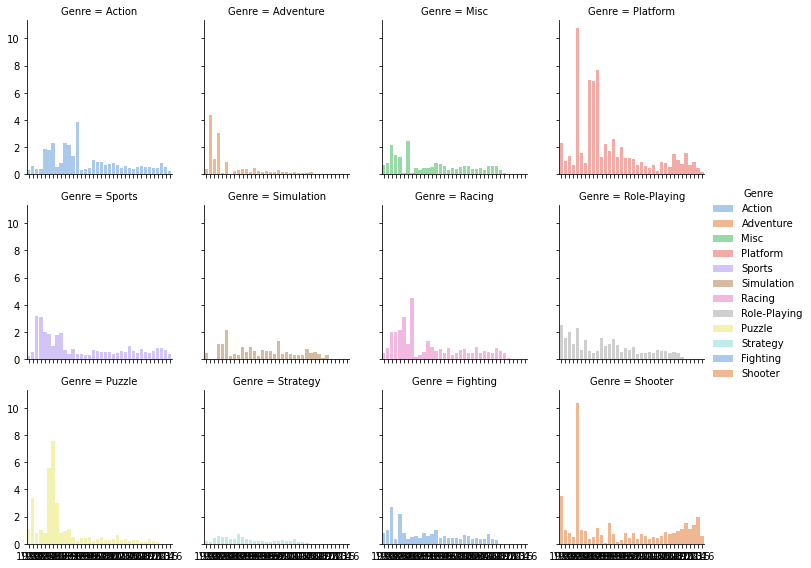

In [ ]:
g = sns.FacetGrid(data = df_year, col = 'Genre', palette = 'pastel', hue = 'Genre', height = 3, col_wrap = 4)

fig = plt.gcf()

fig.set_size_inches(10, 8)

g = g.map_dataframe(
    sns.barplot,
    x = 'Year',
    y = 'Sales',
    data = df_year,
    dodge = False,
    ci=0
    )

g.add_legend();

###### 👉 몇몇 Outlier 제외 장르별 각 게임의 매출 평균선이 비슷한 수준에 있어서 '연도별 총매출'을 지표로 볼 수 있다고 판단.

######✍️ drop하면서 len(df_year3)이 작아지는데 i는 커져서 오류남 -> reversed로 해결!

In [ ]:
df_year3 = df_year.groupby(by = ['Year', 'Genre'], as_index = False).sum()
for i in reversed(range(len(df_year3))):
  if df_year3.iloc[i, 0] == 2017:
    df_year3 = df_year3.drop(i)
  elif df_year3.iloc[i, 0] == 2020:
    df_year3 = df_year3.drop(i)
df_year3.head()

,Year,Genre,Sales
0,1980,Action,0.34
1,1980,Fighting,0.77
2,1980,Misc,2.70
3,1980,Shooter,7.07
4,1981,Action,14.79


In [ ]:
df_pivot = df_year3.pivot_table(index = 'Year', columns = 'Genre', values = 'Sales')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980,0.34,0.0,0.77,2.70,0.00,0.00,0.00,0.0,7.07,0.00,0.00,0.0
1981,14.79,0.0,0.00,0.00,6.92,2.25,0.48,0.0,10.02,0.44,0.78,0.0
1982,6.50,0.0,0.00,0.87,5.03,10.04,1.57,0.0,3.81,0.00,1.06,0.0
1983,2.86,0.4,0.00,2.14,6.93,0.78,0.00,0.0,0.49,0.00,3.20,0.0
1984,1.85,0.0,0.00,1.45,0.69,3.14,5.95,0.0,31.10,0.00,6.17,0.0


In [ ]:
df_pivot.shape

(37, 12)

In [ ]:
df_pivot_col = df_pivot.keys()
df_pivot['maxvalue'] = df_pivot.max(axis = 1)
df_pivot['Rank1'] = 0
df_pivot.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,maxvalue,Rank1
Year,,,,,,,,,,,,,,
1980,0.34,0.0,0.77,2.70,0.00,0.00,0.00,0.0,7.07,0.00,0.00,0.0,7.07,0
1981,14.79,0.0,0.00,0.00,6.92,2.25,0.48,0.0,10.02,0.44,0.78,0.0,14.79,0
1982,6.50,0.0,0.00,0.87,5.03,10.04,1.57,0.0,3.81,0.00,1.06,0.0,10.04,0
1983,2.86,0.4,0.00,2.14,6.93,0.78,0.00,0.0,0.49,0.00,3.20,0.0,6.93,0
1984,1.85,0.0,0.00,1.45,0.69,3.14,5.95,0.0,31.10,0.00,6.17,0.0,31.10,0


In [ ]:
for i in range(len(df_pivot)):
  for m in range(12):
    if df_pivot.iloc[i, m] == df_pivot.iloc[i, 12]:
      df_pivot.iloc[i, 13] = df_pivot_col[m]
df_pivot.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,maxvalue,Rank1
Year,,,,,,,,,,,,,,
1980,0.34,0.0,0.77,2.70,0.00,0.00,0.00,0.0,7.07,0.00,0.00,0.0,7.07,Shooter
1981,14.79,0.0,0.00,0.00,6.92,2.25,0.48,0.0,10.02,0.44,0.78,0.0,14.79,Action
1982,6.50,0.0,0.00,0.87,5.03,10.04,1.57,0.0,3.81,0.00,1.06,0.0,10.04,Puzzle
1983,2.86,0.4,0.00,2.14,6.93,0.78,0.00,0.0,0.49,0.00,3.20,0.0,6.93,Platform
1984,1.85,0.0,0.00,1.45,0.69,3.14,5.95,0.0,31.10,0.00,6.17,0.0,31.10,Shooter


#👩‍💻 시각화 📊

❗️ y축의 높낮이는 숫자적 의미를 가지지 않는다. ❗️

In [ ]:
df_pivot_vis = df_pivot.reset_index()

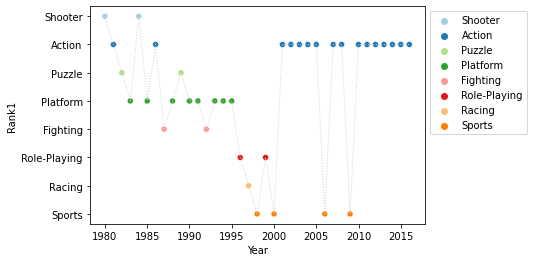

In [ ]:
plt.plot(df_pivot_vis['Year'], df_pivot_vis['Rank1'], color = 'lightgray', ls = ':', lw = 1)
sns.scatterplot(x = 'Year', y = 'Rank1', data = df_pivot_vis, hue = 'Rank1', palette = 'Paired')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show();

#####✍️ 2000년대에 들어서고 나서는 Action과 Sports 게임이 매출의 1위를 다투고 있음을 알 수 있습니다.

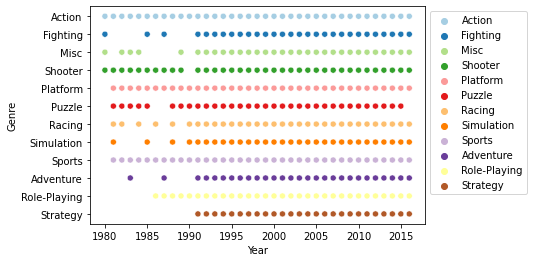

In [ ]:
sns.scatterplot(x = 'Year', y = 'Genre', data = df_year3, hue = 'Genre', palette = 'Paired')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show();

#✍️ Chi-square Test 시작

###### ✍️ 출시를 하고 매출이 발생한 '사건'이 트렌드를 알아보는 지표가 될 수 있다고 판단, Chi square Test 채택 및 진행

In [ ]:
df_year4 = df_year

In [ ]:
df_year4.loc[:, 'Count'] = 0
df_year4.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Year,Genre,Sales,Count
1,2008,Action,0.04,0
2,2009,Action,0.18,0
3,2010,Adventure,0.02,0
4,2010,Misc,0.04,0
5,2010,Platform,0.25,0


In [ ]:
for n in range(len(df_year4)):
  if df_year4.iloc[n, 2] > 0:
    df_year4.iloc[n, 3] = 1
df_year4 = df_year4.drop('Sales', axis = 1)
df_year4.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Year,Genre,Count
1,2008,Action,1
2,2009,Action,1
3,2010,Adventure,1
4,2010,Misc,1
5,2010,Platform,1


In [ ]:
df_year5 = df_year4.groupby(by = ['Year', 'Genre'], as_index = False).sum()
for i in reversed(range(len(df_year5))):
  if df_year5.iloc[i, 0] == 2017:
    df_year5 = df_year5.drop(i)
  elif df_year5.iloc[i, 0] == 2020:
    df_year5 = df_year5.drop(i)
df_year5.head()

,Year,Genre,Count
0,1980,Action,1
1,1980,Fighting,1
2,1980,Misc,4
3,1980,Shooter,2
4,1981,Action,25


✍️

**1) 귀무가설$H_0:$ 게임 장르와 연도는 연관성이 없다.(상호 독립이다.)**

**2) 대안가설$H_1:$ 게임 장르와 연도는 연관성이 있다.**

**3) 신뢰도: 99%:** $\alpha = 0.01$

######✍️ library쓰기위해 wide형태로 만들어주기, 각 셀의 빈도가 5 이상이어야 하기 때문에 1995-2015년도 사이의 데이터 분석

In [ ]:
df_year_chi = df_year5.pivot_table(index = 'Year', columns = 'Genre', values = 'Count')
df_year_chi = df_year_chi.fillna(0)
df_year_chi = df_year_chi.applymap(int)
df_year_chi = df_year_chi[15:-1]
df_year_chi.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1995,8,13,29,22,13,12,12,24,29,14,29,14
1996,20,17,30,23,14,9,21,28,23,13,52,12
1997,31,14,28,12,18,14,36,23,27,19,46,21
1998,44,23,41,21,25,13,48,26,23,8,70,35
1999,39,19,24,25,18,6,49,32,16,20,62,26
2000,43,16,29,20,24,12,43,29,20,15,81,16
2001,66,20,18,26,43,15,71,41,36,28,96,20
2002,125,41,54,45,77,20,103,54,78,19,188,22
2003,144,12,44,53,87,7,109,48,73,35,125,37


In [ ]:
chi2_contingency(df_year_chi)[0:3]

(2123.2628519138293, 4.549275444508991e-308, 220)

**$X^2$:** 2123.2628519138293

**p-value:** 4.549275444508991e-308

**Degrees of freedom:** 220

👉 $Reject H_0$

게임 장르와 연도는 신뢰수준 99%로 연관성이 없다고 볼 수 있다.

# 🙌 Chi-square Test 끝

# 🧾같은 방법으로 Platform 트렌드를 살펴보자

In [ ]:
df_plat = df
df_plat['Sales'] = df_plat['NA'] + df_plat['EU'] + df_plat['JP'] + df_plat['Other']
df_plat = df_plat[['Year', 'Platform', 'Sales']]
df_plat.head()

,Year,Platform,Sales
1,2008,DS,0.04
2,2009,Wii,0.18
3,2010,PSP,0.02
4,2010,DS,0.04
5,2010,PS3,0.25


In [ ]:
df_plat = df_plat.groupby(by = ['Year', 'Platform'], as_index = False).sum()
for i in reversed(range(len(df_plat))):
  if df_plat.iloc[i, 0] == 2017:
    df_plat = df_plat.drop(i)
  elif df_plat.iloc[i, 0] == 2020:
    df_plat = df_plat.drop(i)
df_plat.head()

,Year,Platform,Sales
0,1980,Unknown,10.88
1,1981,Unknown,35.68
2,1982,Unknown,28.88
3,1983,NES,10.96
4,1983,Unknown,5.84


In [ ]:
df_pivot_plat = df_plat.pivot_table(index = 'Year', columns = 'Platform', values = 'Sales')
df_pivot_plat = df_pivot_plat.fillna(0)
df_pivot_plat.head()

Platform,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,Unknown,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.88,0.0,0.0,0.0,0.0,0.0,0.0
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.68,0.0,0.0,0.0,0.0,0.0,0.0
1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0
1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.84,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_pivot_plat.shape

(37, 31)

In [ ]:
df_pivot_col_plat = df_pivot_plat.keys()
df_pivot_plat['maxvalue'] = df_pivot_plat.max(axis = 1)
df_pivot_plat['Rank1'] = 0
df_pivot_plat.head()

Platform,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,Unknown,WS,Wii,WiiU,X360,XB,XOne,maxvalue,Rank1
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.88,0.0,0.0,0.0,0.0,0.0,0.0,10.88,0
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.68,0.0,0.0,0.0,0.0,0.0,0.0,35.68,0
1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0
1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.84,0.0,0.0,0.0,0.0,0.0,0.0,10.96,0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,50.08,0


In [ ]:
for i in range(len(df_pivot_plat)):
  for m in range(31):
    if df_pivot_plat.iloc[i, m] == df_pivot_plat.iloc[i, 31]:
      df_pivot_plat.iloc[i, 32] = df_pivot_col_plat[m]
df_pivot_plat = df_pivot_plat.reset_index()
df_pivot_plat.head()

Platform,Year,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,Unknown,WS,Wii,WiiU,X360,XB,XOne,maxvalue,Rank1
0,1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.88,0.0,0.0,0.0,0.0,0.0,0.0,10.88,Unknown
1,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.68,0.0,0.0,0.0,0.0,0.0,0.0,35.68,Unknown
2,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,28.88,Unknown
3,1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.84,0.0,0.0,0.0,0.0,0.0,0.0,10.96,NES
4,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,50.08,NES


#👩‍💻 시각화 📊

❗️ y축의 높낮이는 숫자적 의미를 가지지 않는다. ❗️

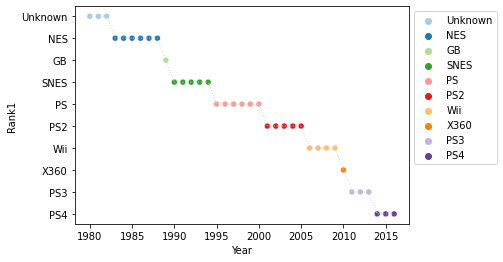

In [ ]:
plt.plot(df_pivot_plat['Year'], df_pivot_plat['Rank1'], color = 'lightgray', ls = ':', lw = 1)
sns.scatterplot(x = 'Year', y = 'Rank1', data = df_pivot_plat, hue = 'Rank1', palette = 'Paired')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show();

###### 👉 시간이 지남에 따라 Platform의 트렌드가 바뀌는 것을 볼 수 있다(새로운 Platform이 자꾸 나와서 유행이 바뀌는 듯 하다).


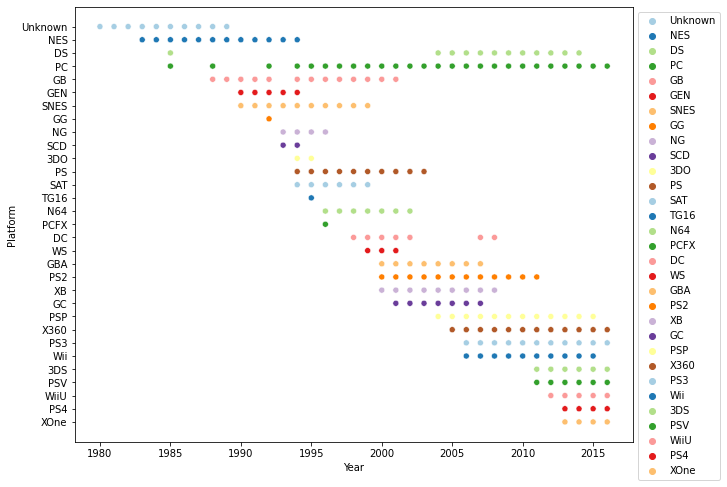

In [ ]:
fig = plt.gcf()

fig.set_size_inches(10, 8)
sns.scatterplot(x = 'Year', y = 'Platform', data = df_plat, hue = 'Platform', palette = 'Paired')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show();

##### 👉 각 셀의 빈도수가 5 이하가 대부분이기 때문에 Chi square Test를 진행할 수 없다.

# ❓매출이 높은 게임에 대한 분석 및 시각화 프로세스❓

In [ ]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


######✍️ 상위 1%만 뽑아서 DataFrame만들기

In [ ]:
df_sales = df
df_sales['Sales'] = df_sales['NA'] + df_sales['EU'] + df_sales['JP'] + df_sales['Other']

In [ ]:
df_sales.shape

(16277, 10)

In [ ]:
df_top_sales = df_sales.sort_values(by = ['Sales'], axis = 0, ascending = False)
df_top_sales = df_top_sales.iloc[:162]
df_top_sales.reset_index(inplace = True, drop = True)
df_top_sales.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38


In [ ]:
df_melt_country = df_top_sales.melt(id_vars = ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Sales'], value_vars = ['NA', 'EU', 'JP', 'Other'])
df_melt_country.columns = ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Sales_total', 'Country', 'Sales']
df_melt_country.head()

,Name,Platform,Year,Genre,Publisher,Sales_total,Country,Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,82.74,NA,41.49
1,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24,NA,29.08
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.83,NA,15.85
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,33.00,NA,15.75
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,31.38,NA,11.27


In [ ]:
df_melt_country.nunique()

Name           146
Platform        21
Year            30
Genre           11
Publisher       19
Sales_total    159
Country          4
Sales          408
dtype: int64

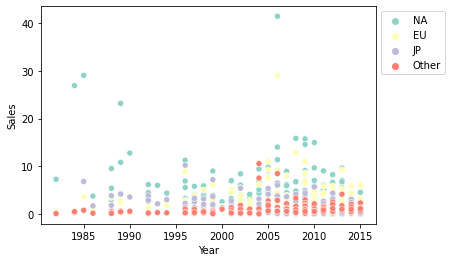

In [ ]:
sns.scatterplot(x = 'Year', y = 'Sales', hue = 'Country', data = df_melt_country, palette = 'Set3')
sns.dark_palette('purple')
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

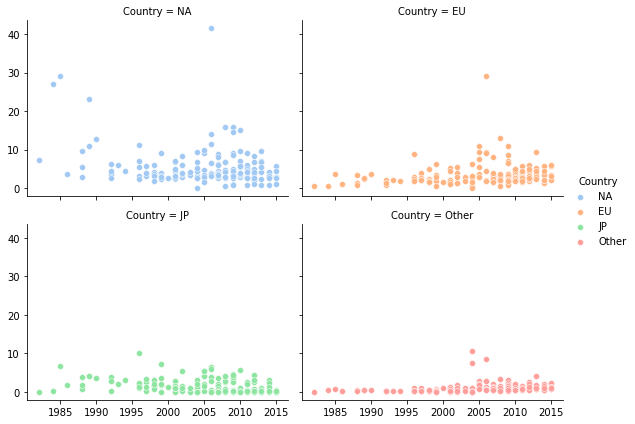

In [ ]:
g = sns.FacetGrid(data = df_melt_country, col = 'Country', palette = 'pastel', hue = 'Country', height = 2, col_wrap = 2)

fig = plt.gcf()

fig.set_size_inches(8, 6)

g.map_dataframe(
    sns.scatterplot,
    x = 'Year',
    y = 'Sales',
    data = df_melt_country,
    palette = 'pastel'
    )
g.add_legend();

✍️ 북미에서 Sales가 높게 형성되는 경향이 있다.

-> 북미에서 잘 팔리면 Sales가 전체적으로 높다?(correlation between NA and Total Sales)

In [ ]:
df_sales1 = df
df_sales1['Sales'] = df_sales1['NA'] + df_sales1['EU'] + df_sales1['JP'] + df_sales1['Other']
df_sales1 = df_sales1[['NA', 'Sales', 'Year']]
df_sales1.corr()

,NA,Sales,Year
NA,1.000000,0.941654,-0.091934
Sales,0.941654,1.000000,-0.075770
Year,-0.091934,-0.075770,1.000000


✍️ NA Sales와 Total Sales의 상관관계가 높다.

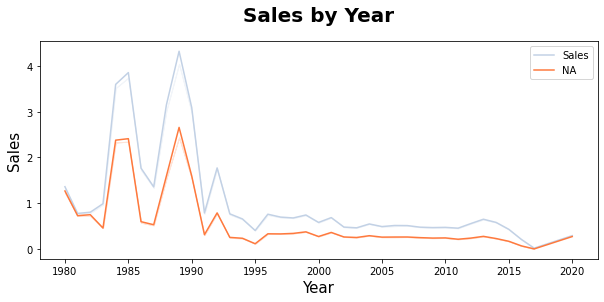

In [ ]:
plt.figure(figsize = (10, 4))
sns.set_palette('pastel')
sns.lineplot(x = 'Year', y = 'Sales', data = df_sales1, label = 'Sales', color = '#c2d1e5', ci = 0)
sns.lineplot(x = 'Year', y = 'NA', data = df_sales1, label = 'NA', color = '#fe793d', ci = 0)
plt.title('Sales by Year', fontweight = 'bold', fontsize = 20, pad = 20)
plt.legend()
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Sales', fontsize = 15);

In [ ]:
df_top_sales['Year'].value_counts().head()

2011    13
2010    13
2009    13
2008    10
2007    10
Name: Year, dtype: int64

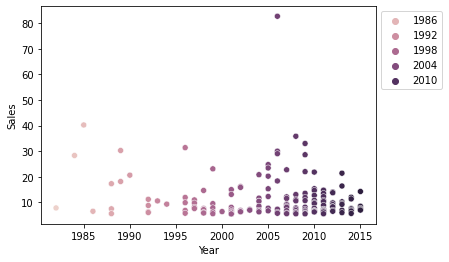

In [ ]:
sns.scatterplot(x = 'Year', y = 'Sales', hue = 'Year', data = df_top_sales)
sns.dark_palette('purple')
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

✍️ 2009 - 2011년도 사이의 게임들이 top1%매출에 많이 들어있다.(cumulative Sales때문인듯 하다.)

In [ ]:
df_top_sales['Genre'].value_counts()

Shooter         32
Action          28
Platform        24
Role-Playing    22
Racing          16
Sports          11
Misc            11
Fighting         7
Simulation       5
Puzzle           4
Adventure        2
Name: Genre, dtype: int64

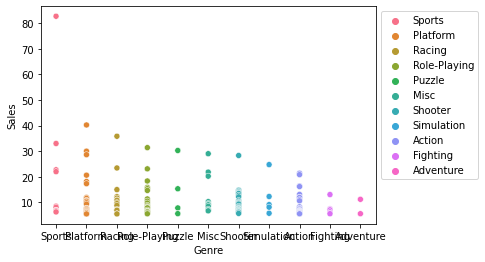

In [ ]:
sns.scatterplot(x = 'Genre', y = 'Sales', hue = 'Genre', data = df_top_sales)
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

✍️ 장르가 Shooter, Action, Platform, Role-Playing인 게임들이 top1%매출에 많이 들어있다.

장르가 각각 Sports, Platform, Racing인 게임이 개별 매출top3다.

(트렌드에서 Action이 조금 압도적이지만 Action과 Sports가 1위를 다투고 있었다.)

In [ ]:
df_top_sales['Platform'].value_counts()

X360       24
PS3        23
Wii        20
DS         16
PS         12
PS2        11
PS4         8
GB          7
GBA         6
3DS         6
NES         6
SNES        5
N64         5
GC          3
PC          2
XB          2
PSP         2
Unknown     1
WiiU        1
XOne        1
GEN         1
Name: Platform, dtype: int64

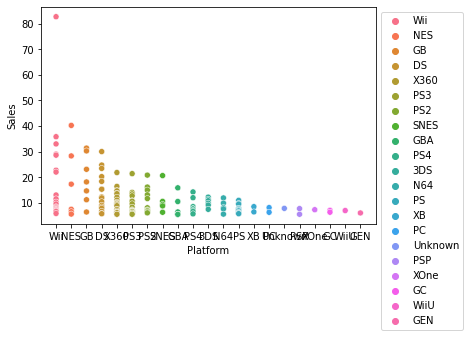

In [ ]:
sns.scatterplot(x = 'Platform', y = 'Sales', hue = 'Platform', data = df_top_sales)
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

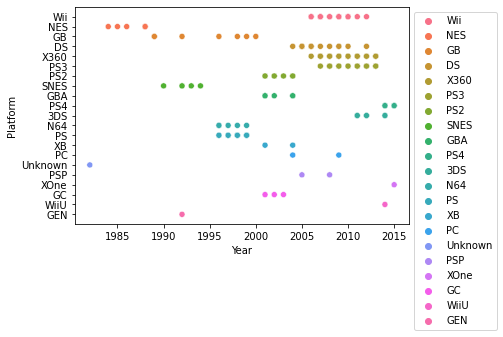

In [ ]:
sns.scatterplot(x = 'Year', y = 'Platform', hue = 'Platform', data = df_top_sales)
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

✍️ Platform을 X360, PS3, Wii을 쓰는 게임들이 top1%매출에 많이 들어있다.

(트렌드에서 알아보았던 PS1, 2, 4또한 top1%에 많이 들어있다.)

In [ ]:
df_top_sales['Publisher'].value_counts()

Nintendo                                  66
Activision                                18
Sony Computer Entertainment               16
Microsoft Game Studios                    13
Electronic Arts                           12
Take-Two Interactive                      11
Ubisoft                                    7
Bethesda Softworks                         3
Konami Digital Entertainment               3
505 Games                                  2
Sega                                       2
Capcom                                     2
GT Interactive                             1
Virgin Interactive                         1
LucasArts                                  1
Atari                                      1
Sony Computer Entertainment Europe         1
Warner Bros. Interactive Entertainment     1
SquareSoft                                 1
Name: Publisher, dtype: int64

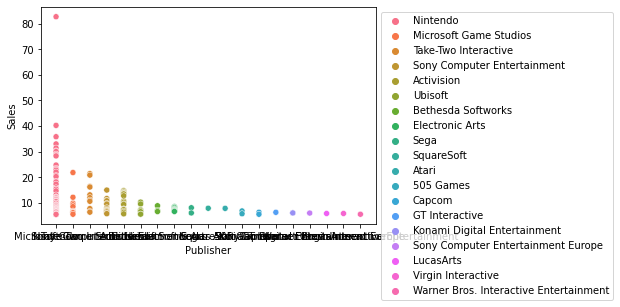

In [ ]:
sns.scatterplot(x = 'Publisher', y = 'Sales', hue = 'Publisher', data = df_top_sales)
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

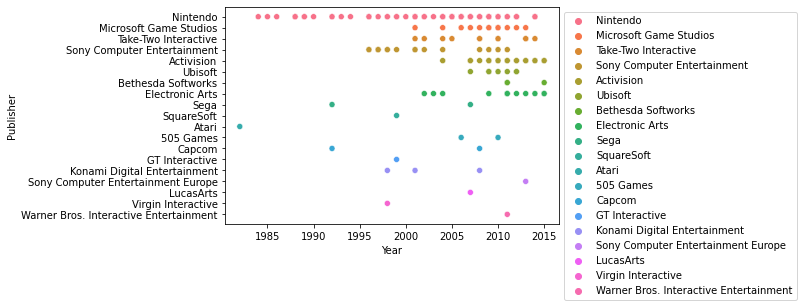

In [ ]:
sns.scatterplot(x = 'Year', y = 'Publisher', hue = 'Publisher', data = df_top_sales)
plt.legend(bbox_to_anchor = (1, 1), loc = 2);

✍️ Nintendo가 top1%매출에서도 많은 비율을 차지하고 있으며 꾸준히 매출을 내고 있다.

벤치마킹이 필수라는 것을 알 수 있다.